In [1]:
from model.standard_lstm import StandardLSTM
instance = StandardLSTM(1001115026824)
# score = instance.fit_model()

Using TensorFlow backend.


In [2]:
instance.one_step_prediction()

TypeError: one_step_prediction() missing 4 required positional arguments: 'train_X', 'cross_X', 'test_X', and 'mag_scaler'

In [ ]:
instance.multiple_step_prediction()

In [3]:
import pickle 
with open('/Users/mingyu/Desktop/dataset/processed_data/basic/1001115026824.pickle', 'rb') as handle: 
    file = pickle.load(handle)

(1, 87)


In [ ]:
from main_pipeline import MainPipeline
main_pipeline = MainPipeline(1001115026824)

In [1]:
from model import mc_dnn 
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
from model.mc_dnn import MCDnn
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def build_dataset(N, noise_std=0.25, is_test=True):
    x = np.random.rand(N, 1)

    if is_test:
        x = 8 * x - 4
    else:
        x = 6 * x - 3
        x[x < 0] -= 1
        x[x > 0] += 1

    # data with noise
    y = 0.1 * x ** 3 + np.random.normal(0, noise_std, size=(N, 1))

    return x, y

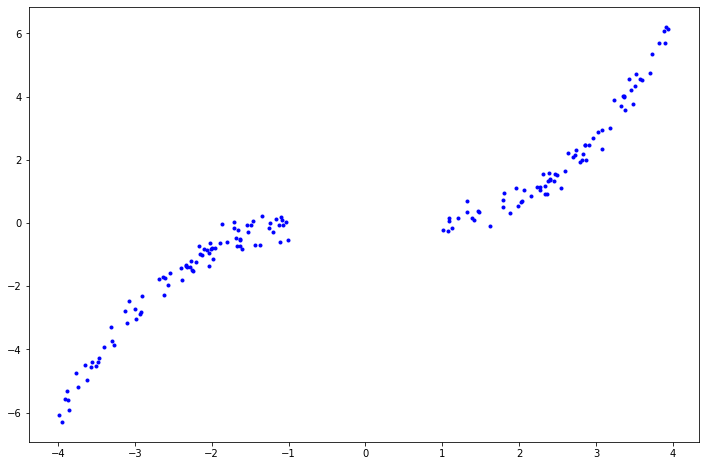

In [3]:
# Raw Data
x_train_val, y_train_val = build_dataset(200, noise_std=0.25, is_test=False)
x_test, y_test = build_dataset(800, noise_std=0.25, is_test=True)

# Split Data
num_training_examples = int(0.8 * np.shape(x_train_val)[0])
x_train = x_train_val[0:num_training_examples, :]
y_train = y_train_val[0:num_training_examples]
x_validation = x_train_val[num_training_examples:, :]
y_validation = y_train_val[num_training_examples:]

# Plot Data 
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'b.')

In [4]:
# Parameters
dropout_rates = [0.005, 0.01, 0.05, 0.1]
tau_values = [0.025, 0.05, 0.075]
n_hidden = 50
num_hidden_layers = 2
n_epochs = 5000
batch_size=128

best_network = None
best_ll = -float('inf')
best_tau = 0
best_dropout = 0
for dropout_rate in dropout_rates:
    for tau in tau_values:
        print('\nGrid search step: Tau: ' + str(tau) + ' Dropout rate: ' + str(dropout_rate))
        MC_dnn = MCDnn(n_hidden = [int(n_hidden)]*num_hidden_layers, n_epochs=n_epochs, batch_size=batch_size, tau=tau, dropout=dropout_rate)
        MC_dnn.build_model(x_train, y_train)
        _, _, _, ll = MC_dnn.predict(x_validation, y_validation)

        if (ll > best_ll):
            best_ll = ll
            best_network = MC_dnn
            best_tau = tau
            best_dropout = dropout_rate
            print('Best log_likelihood changed to: ' + str(best_ll))
            print('Best tau changed to: ' + str(best_tau))
            print('Best dropout rate changed to: ' + str(best_dropout))


Grid search step: Tau: 0.025 Dropout rate: 0.005


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





/Users/mingyu/Desktop/Attention-Mechanism-in-Predictive-Astronomy/src/model/mc_dnn.py:49: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", kernel_regularizer=<keras.reg...)`
  inter = Dense(self.n_hidden[0], activation='relu', W_regularizer=l2(reg))(inter)
/Users/mingyu/Desktop/Attention-Mechanism-in-Predictive-Astronomy/src/model/mc_dnn.py:52: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", kernel_regularizer=<keras.reg...)`
  inter = Dense(self.n_hidden[i + 1], activation='relu', W_regularizer=l2(reg))(inter)
/Users/mingyu/Desktop/Attention-Mechanism-in-Predictive-Astronomy/src/model/mc_dnn.py:54: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg...)`
  outputs = Dense(y_train.shape[1], W_regularizer=l2(reg))(inter)



40/40 [==============================] - 0s 554us/step
Best log_likelihood changed to: -2.7654709157902504
Best tau changed to: 0.025
Best dropout rate changed to: 0.005

Grid search step: Tau: 0.05 Dropout rate: 0.005
40/40 [==============================] - 0s 865us/step
Best log_likelihood changed to: -2.4210158247902034
Best tau changed to: 0.05
Best dropout rate changed to: 0.005

Grid search step: Tau: 0.075 Dropout rate: 0.005
40/40 [==============================] - 0s 1ms/step
Best log_likelihood changed to: -2.220276354086451
Best tau changed to: 0.075
Best dropout rate changed to: 0.005

Grid search step: Tau: 0.025 Dropout rate: 0.01
40/40 [==============================] - 0s 2ms/step

Grid search step: Tau: 0.05 Dropout rate: 0.01
40/40 [==============================] - 0s 2ms/step

Grid search step: Tau: 0.075 Dropout rate: 0.01
40/40 [==============================] - 0s 2ms/step

Grid search step: Tau: 0.025 Dropout rate: 0.05
40/40 [==============================] -

In [5]:
best_network = MCDnn([int(n_hidden)] * num_hidden_layers, n_epochs=n_epochs, tau=best_tau, dropout=best_dropout)
best_network.build_model(x_train, y_train)
standard_pred, MC_pred, MC_std, ll = best_network.predict(x_test, y_test)

800/800 [==============================] - 0s 244us/step


/Users/mingyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  


<ErrorbarContainer object of 3 artists>

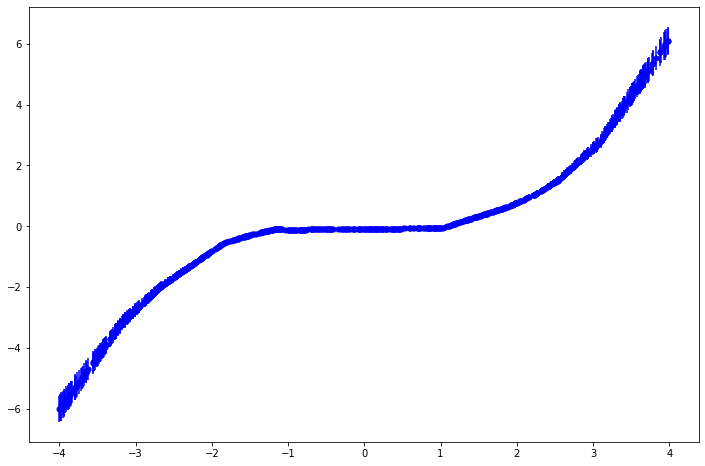

In [6]:
plt.figure(figsize=(12, 8))
plt.errorbar(x_test, MC_pred, MC_std, fmt='b.', markersize=10, label='Validation')

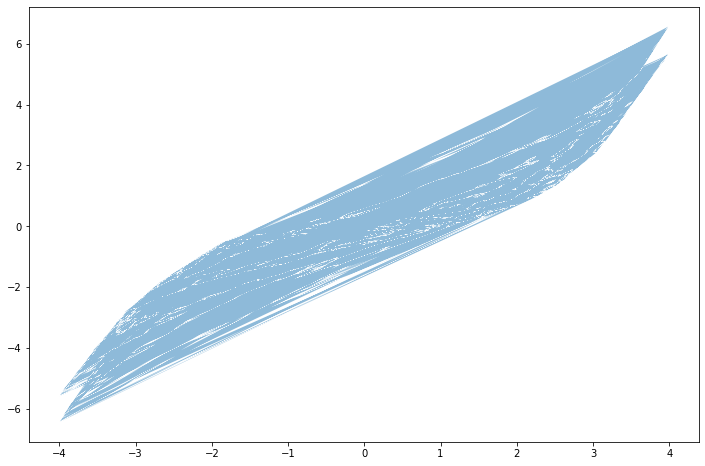

In [7]:
MC_pred_high = (MC_pred + MC_std).reshape(800)
MC_pred_low = (MC_pred - MC_std).reshape(800)
x_test = x_test.reshape(800)
plt.figure(figsize=(12, 8))
plt.fill_between(x_test, y1=MC_pred_high, y2=MC_pred_low, alpha=0.5)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

In [4]:
print(np.shape(X))

(6, 1)


In [5]:
print(np.shape(y))

(6,)
